
# ML Model To Predict NSUN6 Affected Genes



## Imports & Set-Up

Currently just using the 50:50 area selection

In [1]:
import random
import math
import pandas as pd
import numpy as np
from pyfaidx import Fasta
import matplotlib.pyplot as plt
from matplotlib import colors
import logomaker as lm
import re

dataset = pd.read_csv("out\\NSUN6_dataset_2405241153.csv", index_col = 0)


## Dealing With The "p>>n" Problem

The current datasets created have 4756 features (n) but only 227 samples in the positive dataset and 75 samples in the negative dataset (p). To mitigate this imbalance which could lead to over-fitting and similar issues various methods should be considered to reduce the size of n (or increase the size of p).

There is no best method and it is recommended to use controlled experiments to test a suite of different methods...

Whilst the features 'A', 'C', 'T', 'G' are obviously crucial, we need to identify how to reduce the base pairing probability down to just the problem-significant components.

From a quick inspection all base-pairing probabilities (bpp) have the same likelihood of being blank as each other, normally ~200/227 samples are blank!


### Dimensional Reduction [PCA, tSNE]

PCA is less effective at preserving local structures. tSNE is frequently used for bioinformatics/biomedical signal processing but it requires hyperparameter like perplexity and number of steps.

Only use the highly variable features???


In [43]:
bpp_set = dataset.iloc[:,6:] # Only want to reduce the base pairing features


# Replace NaNs with 0 probability
bpp_set = bpp_set.fillna(0)

# Target, classification value
y = dataset['NSUN6_affected'].values
# Features
X = bpp_set.values

# Standardiser?
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
principalComponents = pca.fit_transform(X,y)

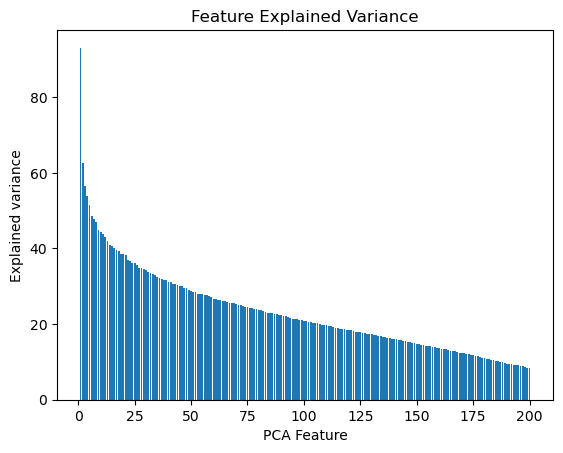

In [44]:
import matplotlib.pyplot as plt 

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )

plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

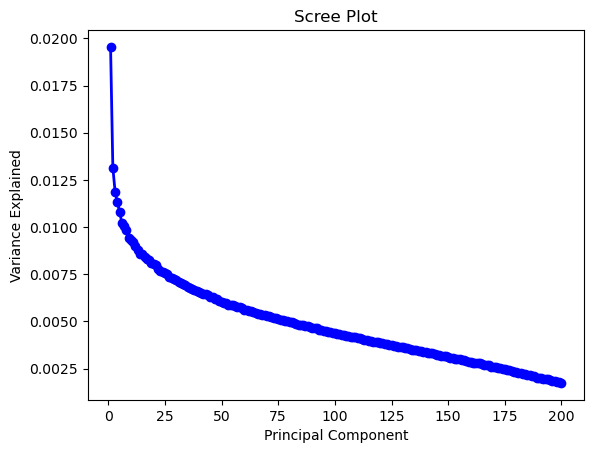

In [45]:
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#print(pca.explained_variance_ratio_ * 100)

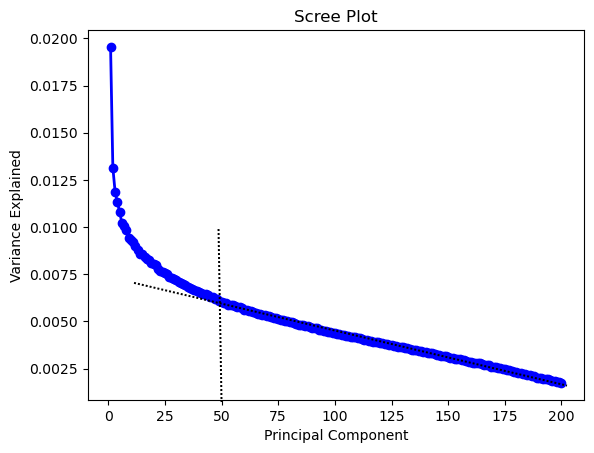

Assume a good number of principle components is 50

In [80]:
ideal_count_pca = 50

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=ideal_count_pca)
principalComponents = pca.fit_transform(X,y)

# Recollect the information
columns=[]
for i in range (0,ideal_count_pca):
    columns.append('PCA_'+str(i+1))

bpp_values_df = pd.DataFrame(data=principalComponents, columns=columns)
nsun6_affected_series = pd.Series(y, name='affected')
data_without_seq = pd.concat([nsun6_affected_series, bpp_values_df], axis=1)
data_with_seq = pd.concat([data_without_seq, 
                           pd.DataFrame(data=dataset.iloc[:,2:6].values, columns=['A', 'C','G', 'T'])], 
                           axis=1)
print(data_without_seq.shape)
print(data_with_seq.shape)

(456, 51)
(456, 55)



## Model Generation



## Training & Testing Data Split


In [101]:
from sklearn.model_selection import train_test_split
data_used = data_without_seq

y = data_used['affected']
X = data_used.loc[:,data_used.columns != 'affected']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(364, 54)
(92, 54)



### Logistic Model


In [102]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

In [100]:
model.score(X_test, y_test)

0.9456521739130435